In [1]:
using Random

In [2]:
include("../rollout.jl")

In [3]:
include("../testfns.jl")

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

### Issues
- Use control variates to see how they affect the rollout acquisition functions

#### Probability of Improvement
The probability of improvement (POI) is defined as follows:

$$
POI(x) = \Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right)
$$

where $f^+$ denotes the best value (maximum) known, $\mu(x)$ is the predictive mean at x, $\sigma(x)$ is the predictive variance, $\xi$ is our exploration parameter, and $\Phi$ is the standard normal cumulative distribution function.
<hr>

#### Expected Improvement
The expected improvement (EI) is defined as follows:

$$
EI(x) = (\mu(x) - f^+ - \xi)\Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right) +
        \sigma(x)\phi\left(\frac{\mu(x) - f^+ - \xi}{\sigma(x)}\right)
$$

where $\phi$ is the standard normal probability density function.
<hr>

In [210]:
# Global parameters
MAX_SGD_ITERS = 1000
BATCH_SIZE = 8
HORIZON = 0
MC_SAMPLES = 250
BUDGET = 1;

### 1. Generate low-discrepancy sequence for Quasi-Monte Carlo

In [211]:
# Setup toy problem
# testfn = TestFunction(
#     1, [0. 1.], [.5],
#     x -> 0. + 1e-6*randn(),
#     ∇x -> [0. + 1e-6*randn()]
# )
testfn = TestAckley(1)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

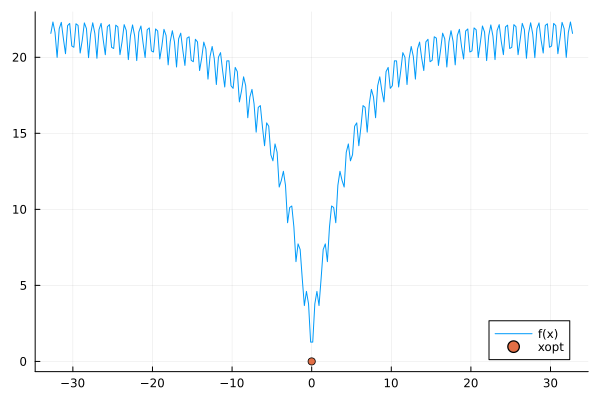

In [212]:
tplot(testfn)

### 2. Gather initial samples/experimental data

In [213]:
# Gather initial samples/experimental data
N, θ = 1, [.25]
X = [22.7, 17.8, 15.8, -15.8, -17.8, -22.7]
X = reshape(X, 1, length(X))
# ψ = kernel_matern52(θ);
ψ = kernel_scale(kernel_matern52, [1., θ...]);

### 3. Construct the ground truth surrogate model

In [214]:
sur = fit_surrogate(ψ, X, testfn.f);
res = optimize_hypers_optim(sur, kernel_matern52)
σ, ℓ = Optim.minimizer(res)
ψ = kernel_scale(kernel_matern52, [σ, ℓ]);
sur = fit_surrogate(ψ, X, testfn.f);

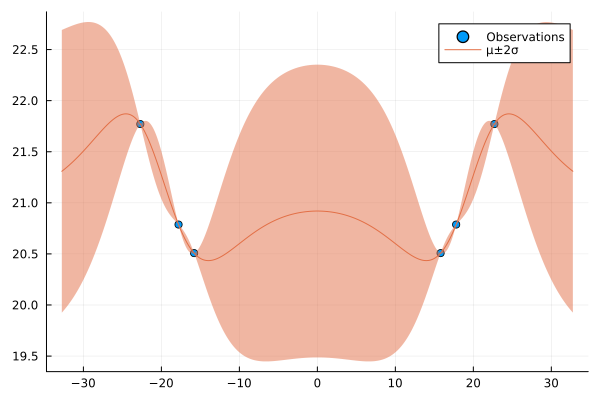

In [215]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
plot1D(sur; domain=domain)

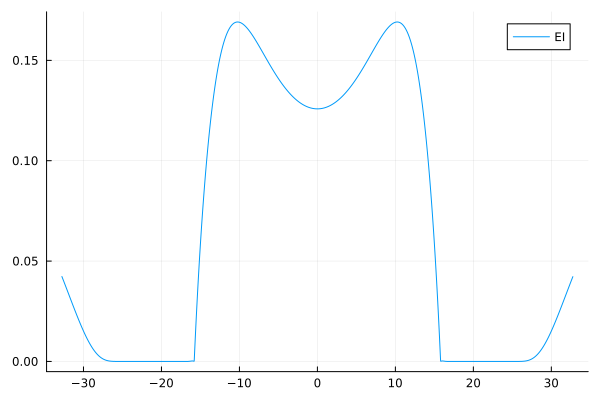

In [216]:
plot1DEI(sur, domain=domain)

### 4. Setup hyperparameters for stochastic gradient descent

In [217]:
# Define the parameters of the nesterov optimizer
λ = 1.  # Learning rate
v = zeros(testfn.dim) # momentum
γ = .99

0.99

### 5. While budget has not been exhausted
Each location in our minibatch is going to be our $x^0$ that serves as our deterministic start location. Then, we perform rollout from that point forward, computing several sample trajectories to then be averaged.

In [218]:
function check_convergence(values)
    # Check that the vector has at least three elements
    if length(values) < 3
        return false
    end

    # Check for a sign change in the last three values
    last_three = values[end-2:end]
    if last_three[1] < 0 && last_three[3] > 0
        return true
    end

    return false
end


check_convergence (generic function with 2 methods)

In [219]:
∇αxs = []
batch = []

final_locations = []
xs = []

println("Beginning Bayesian Optimization Loop")
for b in 1:BUDGET
    # Generate a batch of evaluation locations and filter out locations that are close
    # to know sample locations
    # batch = generate_batch(BATCH_SIZE; lbs=lbs, ubs=ubs)
    batch = [-7.;;]
    
    batch_evals = []
    final_locations = []
    
    # This should be a parallel for loop
    println("---------- BO Iteration #$b ----------")
    bndx = 1
    for x0 in eachcol(batch)
        try
            println(x0)
            x0 = convert(Vector{Float64}, x0)

            αxs, ∇αxs = [], []
            ∇αxs = []

            print("\n(Batch #$bndx - $x0) Gradient Ascent Iteration Count: ")
            # Run SGD until convergence
            for epoch in 1:MAX_SGD_ITERS
                if mod(epoch-1, 250) == 0 print("|") end
                # Compute the look ahead gradient
                push!(xs, x0)
                forward_x0 = x0 + γ*v
                μx, ∇μx = simulate_trajectory(
                    sur; mc_iters=MC_SAMPLES, rnstream=lds_rns, lbs=lbs, ubs=ubs, x0=forward_x0, h=HORIZON
                )
                
                # Update optimizer parameters
                v = γ*v + λ*∇μx
                x0 = x0 + v

                # Update gradient vector
                push!(αxs, μx)
                push!(∇αxs, first(∇μx))
                
                if check_convergence(∇αxs)
                    println("Converged after $epoch epochs")
                    break
                end
            end

            bndx += 1
        catch e
            bndx += 1
            println(e)
        end
    end
    # Iterate over batch for best response and sample original process afterwards
#     if length(batch_evals) > 0
#         println()
#         [println("α($(pair[1])) = $(pair[2])") for pair in zip(final_locations, batch_evals)]
#         ndx = argmax(batch_evals)
#         xnew = final_locations[ndx]

#         # Sample original process at x0
#         println("\nFinal xnew: $xnew")
#         println("--------------------------------------\n")
#         res = optimize_hypers_optim(sur, kernel_matern52)
#         σ, ℓ = Optim.minimizer(res)
#         println("Learned Kernel Hyperparameters: σ=$σ -- ℓ=$ℓ")
#         ψ = kernel_scale(kernel_matern52, [σ, ℓ]);
#         recover_y = sur.y .+ sur.ymean
#         sur = fit_surrogate(
#             ψ,
#             hcat(sur.X, xnew),
#             vcat(recover_y, testfn.f(xnew))
#         )
        
#         push!(minis, minimum(sur.y) + sur.ymean)
#     end
    println("Done!")
end

Beginning Bayesian Optimization Loop
---------- BO Iteration #1 ----------
[-7.0]

(Batch #1 - [-7.0]) Gradient Ascent Iteration Count: ||||Done!


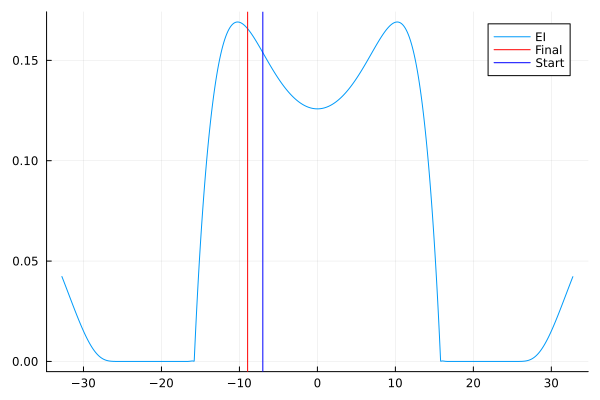

In [221]:
plot1DEI(sur, domain=domain)
vline!(xs[end], color=:red, label="Final")
vline!(xs[1], color=:blue, label="Start")

In [222]:
grad_norms = norm.([first(v) for v in ∇αxs]);
grad_diffs = (grad_norms[1:end-1] - grad_norms[2:end]);
∇αxs;

In [225]:
@printf "%f\n" ∇αxs[1]
@printf "%f\n" ∇αxs[end]

-0.000004
-0.000138


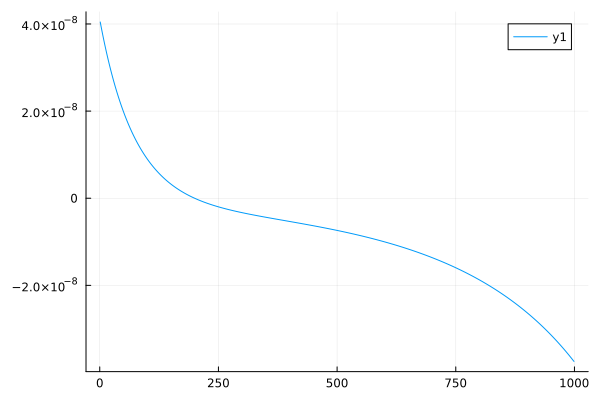

In [203]:
# plot(grad_norms)
plot(grad_diffs)

### Parallel Bayesian Optimization

In [78]:
results = []
BATCH_SIZE = 1

println("Beginning Bayesian Optimization Loop")
for b in 1:BUDGET
    # Generate a batch of evaluation locations and filter out locations that are close
    # to know sample locations
    batch = generate_batch(BATCH_SIZE; lbs=lbs, ubs=ubs)
    batch = [-15.36;;]

    # This should be a parallel for loop
    println("---------- BO Iteration #$b ----------")
    batch_results = @distributed (append!) for j = 1:size(batch, 2)
        # Define the parameters of the optimizer
        λ = 0.01  # Learning rate
        β1 = 0.9  # First moment decay rate
        β2 = 0.999  # Second moment decay rate
        ϵ = 1e-8  # Epsilon value

        # Define the initial position and moment estimates
        m = zeros(testfn.dim)
        v = zeros(testfn.dim)

        ϵsgd = 1e-12
        grad_tol = 1e-8

        x0 = batch[:, j]
        xstart = x0

        αxs, ∇αxs = [], []
        ∇αxs = [0., 1., 2.]

        # Run SGD until convergence
        fprev, fnow = 0., 1.
        try
            iters = 1
            for epoch in 1:MAX_SGD_ITERS
                μx, ∇μx = simulate_trajectory(
                    sur; mc_iters=MC_SAMPLES, rnstream=lds_rns, lbs=lbs, ubs=ubs, x0=x0, h=HORIZON
                )

                # Update gradient vector
                push!(αxs, μx)
                push!(∇αxs, first(∇μx))
                
                fprev = fnow
                fnow = μx
                
                # x0, m, v = update_x_adam(x0; ∇g=-∇μx, λ=λ, β1=β1, β2=β2, ϵ=ϵ, m=m, v=v, lbs=lbs, ubs=ubs)
                x0 = update_x(x0; λ=λ, ∇g=∇μx, lbs=lbs, ubs=ubs)
                push!(xs, x0)

                iters = epoch
                if abs(fnow - fprev) < ϵsgd || norm(∇μx) < grad_tol
                    break
                end
            end
                
            [(x0, αxs[end], iters, xstart)]
        catch e
            println(e)
            [(x0, -Inf, 0, xstart)]
        end
    end
    println("Parallel Eval #$b Done")

    results = batch_results
end


Beginning Bayesian Optimization Loop
---------- BO Iteration #1 ----------
Parallel Eval #1 Done
